In [1]:
import math as m
import numpy as np
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import time
from copy import deepcopy
from numpy.linalg import matrix_power
from scipy.linalg import block_diag

In [2]:
class Kite:
    def __init__(
        self, 
        x: List[float], #kite location
        v: List[float], #kite velocity
        f: float #f value
             ):
        self.x = x
        self.v = v
        self.f = f

In [19]:
class KiteSwarm:
    def __init__(
        self,
        swarm_size: int, #swarm size
        dim: int, #dimentions
        iter_max: int, #max number of iterations
        Nc: int, #control horizont
        Np: int, #horisont of prediction
        integr_steps: int, #number of integration steps --- (Nmax in article)
        step_size: float, #size of integration steps --- (h in article)
        closenes: float, #parameter of closenes --- (q in article)
        deleted_kites: float, #parameter of deleted kites --- (sigma in article)
        dist_min: float, #minimal distance from food to kite's leader
        k: float, #coeffitient of proportional navigation  
        func_num: int #function number
    ):
        #_________PARAMETERS of ALG______
        self.swarm_size = swarm_size
        self.dim = dim
        self.iter_max = iter_max
        self.Nc = Nc # Np have to be greater than Nc ! (do I need to check it?)
        self.Np = Np
        self.integr_steps = integr_steps
        self.step_size = step_size
        self.closenes = closenes
        self.deleted_kites = deleted_kites
        self.dist_min = dist_min
        self.k = k
        
        self.population = [] #list of kites
#         self.memory = []
        self.pool = []
        
        self.vector_r = [] # leader's location and velocity (const for current iter and  swarm)
        self.vector_x_ki = [] # vector for current kite at the moment t
        self.vector_x = [] #
        
        
        #_________PARAMETERS FOR FUNC______
        self.area = 0
        self.exact = 0
        self.function_name = ''
        self.func_num = func_num
        #_________PARAMETERS FOR FUNC______
        leader_kite = []
        first_kite = []
        second_kite = []
        third_kite = []
        best_kite = []
        
        
        #_________ALGORITHM PARAMETERS AND FUNCTIONS______
        self.E = np.eye(self.dim)
        
        self.hE =  self.step_size * self.E
        self.h2E = self.step_size**2 / 2 * self.E
        self.zero_mtrx = np.zeros((self.dim, self.dim))
        
        # init matrix A
        self.A = np.block([
            [self.E, self.hE], \
            [self.zero_mtrx, self.E]
        ])
        
        # init matrix B
        self. B = np.block([
            [self.h2E], \
            [self.hE]
        ])
        
        # init matrix B
        self.Q = self.closenes * np.eye(self.dim * self.Nc)
        
        tmp_A = np.block([
            [self.E, self.hE], \
            [self.zero_mtrx, self.E]
        ])
        
        # init matrix F
        A_list = [list(matrix_power(self.A,i+1)) for i in range(self.Np)]
        self.F = block_diag(*A_list)
        
        
        # init matrix Phi

        self.zero_B = np.zeros((2*self.dim, self.dim))
        
        list_columns = []
        
        # run through the columns
        for i in range(self.Np):
            # run through the rows in current column
            list_row = []
            for j in range(self.Nc):
                    
                if(j <= i):                        
                    list_row.append(matrix_power(self.A, (i-j)).dot(self.B))
                
                else:
                    list_row.append(self.zero_B)
            list_columns.append(list_row)
        self.Phi = np.block(list_columns)
        
#     def init_area(self):
#         # the function and area definition will be there soon
#         pass
    
    def init_area(self):
        if self.func_num == 0:
            self.area = [[-5, 5], [-5, 5]]
    #         kso.area_new = deepcopy(kso.area)
    #         kso.area_radius = (kso.area[0][1] - kso.area[0][0]) / 5
            self.exact = 0
            self.function_name = 'Квадратичная'
        elif self.func_num == 1:
            self.area = [[-500, 500], [-500, 500]]
    #         kso.area_new = deepcopy(kso.area)
    #         kso.area_radius = (kso.area[0][1] - kso.area[0][0]) / 5
            self.exact = 837.9658
            self.function_name = 'Швефеля'
        elif self.func_num == 2:
            self.area = [[-2, 2], [-2, 2]]
    #         kso.area_new = deepcopy(kso.area)
    #         kso.area_radius = (kso.area[0][1] - kso.area[0][0]) / 5
            self.exact = 4.253888
            self.function_name = 'Мульти'
        elif self.func_num == 3:
            self.area = [[-2, 2], [-2, 2]]
    #         kso.area_radius = (kso.area[0][1] - kso.area[0][0]) / 5
            self.exact = 1
            self.function_name = 'Корневая'
        elif self.func_num == 4:
            self.area = [[-10, 10], [-10, 10]]
    #         kso.area_radius = (kso.area[0][1] - kso.area[0][0]) / 5
            self.exact = 1
            self.function_name = 'Шаффер'
        elif self.func_num == 5:
            self.area = [[-5, 5], [-5, 5]]
            self.exact = 20
            self.function_name = 'Растригина'
        elif self.func_num == 6:
            self.area = [[-10, 10], [-10, 10]]
            self.exact = 20
            self.function_name = 'Экли'
        elif self.func_num == 7:
            self.area = [[-5, 5], [-5, 5]]
            self.exact = 14.060606
            self.function_name = 'Skin'
        elif self.func_num == 8:
            self.area = [[-5, 5], [-5, 5]]
            self.exact = 1
            self.function_name = 'Trapfall'
        elif self.func_num == 9:
            self.area = [[-3, 3], [-1, 5]]
            self.exact = 0
            self.function_name = 'Розенброка'
    
    # creration a first population of kites 
    def form_first_pop(self):
        self.population.clear()
        for i in range(self.swarm_size):
            
            coordinate = np.array([np.random.rand() * \
                        (self.area[j][1] - self.area[j][0]) + self.area[j][0] \
                          for j in range(self.dim)])

            velocity = np.array([(
                np.random.rand() * \
                (self.area[j][1] - self.area[j][0]) + self.area[j][0]) / self.integr_steps \
                          for j in range(self.dim)])
            
            member = Kite(coordinate, velocity, 0)
            self.population.append(member)
    
    def func_calculate(self):
        for i in range(self.swarm_size): 
            coordinate = self.population[i].x
            result = self.function(coordinate)
            self.population[i].f = result
    
    
    def func_barr1(self, step4):
        # определим списки
        self.vector_x.clear()
        vector_u = []
        kite_path_barr = [] # стая на каждом шаге
        kite_population_next_step = []
        best_in_each_track = []

        # перелет каждой особи
        for k_i in range(0, self.swarm_size):
            # очистим все списки
            vector_u = list(vector_u)
            vector_u.clear()

    #         kite.vector_x - список всех векторов состояний на горизонте 

            # временно определим vector_r, x_k_i 
            self.vector_x_ki = np.array([np.concatenate([self.population[k_i].x, self.population[k_i].v]) for i in range(self.Np)])

            # deepcopy R, X_ki для мат операций
            tmp_r = deepcopy(self.vector_r)
            tmp_x_ki = deepcopy(self.vector_x_ki)


            # reshape R, X_ki для мат операций
            tmp_r = np.array(tmp_r).reshape((2 * self.dim * self.Np, 1))
            tmp_x_ki = np.array(tmp_x_ki).reshape((2 * self.dim * self.Np, 1))


            # --------------ОПРЕДЕЛЕНИЕ ВЕКТОРА U + reshape--------------
            u = np.linalg.inv(self.Phi.transpose().dot(self.Phi) + self.Q).dot(self.Phi.transpose()).dot(tmp_r - self.F.dot(tmp_x_ki))
            vector_u.append(u) #зачем аппенд если можно сразу преобразовать в вектор? 

            vector_u = np.block(vector_u) #чтобы из списка преобразовать в матрицу?
            vector_u = vector_u.reshape((self.dim, self.Nc)).transpose()
    #         print('u', '\n', vector_u)


            # --------------ОПРЕДЕЛЕНИЕ ВЕКТОРА U  для шага 2.1 или 4--------------
            if(step4 == 0):
                temp = np.zeros((self.Nc, self.Nc))
                temp[0, 0] = 1.0
                u = temp.dot(vector_u)
    #             print('u', '\n', u)


            kite_path_barr.clear()

            # --------------ВЫЧИСЛЕНИЕ НОВЫХ КООРДИНАТ (ТЕКУЩЕГО КОРШУНА) ВЕКТОРА X_ki--------------
            # когда Nc (Nc<Np) заканчивается, u определяем как [0., 0.]
            for i in range(self.Np):

                if(i < len(vector_u)):
                    u_i = vector_u[i]
                else:
                    u_i = np.zeros(self.dim)

                tmp_x = self.A.dot(self.vector_x_ki[i]) + self.B.dot(u_i) 
                coordinate = tmp_x[:self.dim]
                velocity = tmp_x[self.dim: self.dim*2+1]


                # проверка на выход за границы, если вышли - берем крайнее значение
                for j in range(len(coordinate)):
                    if coordinate[j] < self.area[j][0]:
    #                     print('вылетели 1')
                        coordinate[j] = self.area[j][0]
                    elif coordinate[j] > self.area[j][1]:
    #                     print('вылетели 2')
                        coordinate[j] = self.area[j][1]

                    if velocity[j] < self.area[j][0]:
    #                     print('вылетели 3')
                        velocity[j] = self.area[j][0]
                    elif velocity[j] > self.area[j][1]:
    #                     print('вылетели 4')
                        velocity[j] = self.area[j][1]

                result = self.function(coordinate)
                member = Kite(coordinate, velocity, result)
                kite_path_barr.append(member) #записываем сюда весь трэк коршуна, чтобы потом выбрать конкретное положение

            self.vector_x.append(kite_path_barr)

            kite_pb = deepcopy(kite_path_barr)
            kite_pb.sort(reverse=True, key=lambda kite_: kite_.f)
    #         kite_population_next_step.append(deepcopy(kite_path_barr[kite.Np-1]))
            kite_population_next_step.append(deepcopy(kite_pb[0]))

        self.population.clear()
        self.population = deepcopy(kite_population_next_step)
        kite_population_next_step.clear()
        
    # step_size: float, #size of integration steps --- (h = 2 in article)
    def move_kite_1(self):
        u_step3 = []
        T = 10
        i = 0
        for kite_01 in self.population[0:]:
            firts = 6 * (self.leader_kite.x - kite_01.x) / ((self.swarm_size - i)**2 * self.step_size**2)
            second = 4 * kite_01.v / ((self.swarm_size - i) * self.step_size)
            ++i
            result = firts - second
            u_step3.append(result)
        s = np.array([np.concatenate([self.population[i].x, self.population[i].v]) for i in range(self.swarm_size)])
        s = np.transpose(s)
        u_step3 = np.transpose(u_step3)
        x = self.A.dot(s) + self.B.dot(u_step3)
        x = np.transpose(x)
        list1 = []
        for ii in range(self.swarm_size):
            coordinate = x[ii][:self.dim]
            velocity = x[ii][self.dim: self.dim*2+1]
            result = self.function(coordinate)
            member = Kite(coordinate, velocity, result)
            list1.append(member)
        list1.sort(reverse=True, key=lambda kite_: kite_.f)
        self.population[1] = list1[1]
        self.best_kite.append(list1[1])
    
    def delete_kites(self):
        # deleted_kites: float, #parameter of deleted kites --- (sigma in article)
        number_of_deleted = int(round(self.deleted_kites * self.swarm_size / 100, 0))
        for i in range(number_of_deleted):
            if len(self.population) != 0:
                self.population.pop()
        for i in range(number_of_deleted):
            coordinate = np.array([np.random.rand() * \
                                (self.area[j][1] - self.area[j][0]) + self.area[j][0] \
                                  for j in range(self.dim)])

            velocity = np.array([(np.random.rand() * \
                        (self.area[j][1] - self.area[j][0]) + self.area[j][0]) / self.integr_steps \
                                  for j in range(self.dim)])

            result = self.function(coordinate)
            member = Kite(coordinate, velocity, result)
            self.population.append(member)
    
    
    def kso_work(self):
        start = time.monotonic()
        time.sleep(0.1)
        self.init_area()
        self.population.clear()
        self.form_first_pop()
        self.func_calculate()
        self.population.sort(reverse=True, key=lambda kite_: kite_.f)
        self.pool.append(self.population[0])

        # --------- шаг 2 --------- (добавить цикл iter_max)

        self.vector_r = np.array([np.concatenate([self.population[0].x, self.population[0].v]) for i in range(self.Np)])
        for j in range(self.iter_max): 
            for i in range(self.Nc):
                self.func_barr1(1)
            self.population.sort(reverse=True, key=lambda kite_: kite_.f)
            self.pool.append(self.population[0])
            self.vector_r = np.array([np.concatenate([self.population[0].x, self.population[0].v]) for i in range(self.Np)])

        # --------- шаг 3 ---------

            self.leader_kite = self.population[0]
            self.leader_kite.v = np.zeros(self.dim)
            self.first_kite = self.population[1]
            self.second_kite = self.population[2]
            self.third_kite = self.population[3]
            self.best_kite = []
            self.move_kite_1()
            self.population.sort(reverse=True, key=lambda kite_: kite_.f)
            self.pool.append(self.population[0])

        # --------- шаг 4 ---------

            self.func_barr1(0)
            self.population.sort(reverse=True, key=lambda kite_: kite_.f)
            self.pool.append(self.population[0])

        # --------- шаг 5 ---------
            self.delete_kites()
            self.population.sort(reverse=True, key=lambda kite_: kite_.f)
            self.pool.append(self.population[0])

        self.pool.sort(reverse=True, key=lambda kite_: kite_.f)
        end = time.monotonic()

#         print(self.function_name,'\n')
#         print('work time : {:>9.2f}'.format(end-start))

#         print('I:\t\t', self.pool[0].f, '\nI_exact:\t ', self.exact, '\nI_exact - I\t ', self.exact - self.pool[0].f, '\n\nx: ', self.pool[0].x, '\nv: ', self.pool[0].v)
#         self.draw_plots()
        
    def Cpow(x, y, p):
        Cp = np.array([0, 0])
        Cp[0] = x
        Cp[1] = y
        x0 = 0
        y0 = 0
        for i in range(1, p):
            x0 = Cp[0] * x - Cp[1] * y
            y0 = Cp[1] * x + Cp[0] * y
            Cp[0] = x0
            Cp[1] = y0
        return Cp
    
    
    def function(self, coordinate):
        if self.func_num == 0:
            #self.area = [[-5, 5], [-5, 5]]
            return -(np.array(coordinate)**2).sum()

        elif self.func_num == 1:
            #self.area = [[-500, 500], [-500, 500]]
            return coordinate[0] * m.sin(m.sqrt(abs(coordinate[0]))) + coordinate[1] * m.sin(m.sqrt(abs(coordinate[1])))

        elif self.func_num == 2:
            return coordinate[0] * m.sin(4 * m.pi * coordinate[0]) - coordinate[1] * m.sin(4 * m.pi * coordinate[1] + m.pi) +1

        elif self.func_num == 3:
            c6 = Cpow(coordinate[0], coordinate[1], 6);
            func = (1 / (1 + ((c6[0] - 1)**2 + c6[1]**2)**0.5))
            return #(1 / (1 + ()**0.5))

        elif self.func_num == 4:
            return 0.5 - ((m.sin((coordinate[0]**2 + coordinate[1]**2)**0.5))**2 - 0.5) / (1 + 0.001 * (coordinate[0]**2 + coordinate[1]**2))

        elif self.func_num == 5:
            return (- coordinate[0]**2 + 10 * m.cos(2 * m.pi * coordinate[0])) + (-coordinate[1]**2 + 10 * m.cos(2 * m.pi * coordinate[1]))

        elif self.func_num == 6:
            return - m.exp + 20 * m.exp(-0.2 * ((coordinate[0]**2 + coordinate[1]**2) / 2)**0.5) + m.exp(m.cos(2 * m.pi * coordinate[0]) + m.cos(2 * m.pi * coordinate[1])) / 2

        elif self.func_num == 7:
            return (m.cos(2 * coordinate[0]) - 1.1)**2 + (m.sin(0.5 * coordinate[0]) - 1.2)**2 - (m.cos(2 * coordinate[1]) - 1.1)**2 + (m.sin(0.5 * coordinate[1]) - 1.2)**2

        elif self.func_num == 8:
            return -(abs(m.sin(m.sin((abs(m.sin(coordinate[0] - 1)))**0.5 + (abs(m.sin(coordinate[1] + 2)))**0.5))))**0.5 + 1

        elif self.func_num == 9:
            return -(1 - coordinate[0])**2 - 100 * (coordinate[1] - coordinate[0]**2)**2
        
    
    def draw_plots(self):
        plt.figure(figsize=(12, 10))
        x1 = [self.pool[i].x[0] for i in range(1, len(self.pool))]
        x2 = [self.pool[i].x[1] for i in range(1, len(self.pool))]
        plt.plot(x1, x2, 'b.')
        x_1 = self.pool[0].x[0]
        x_2 = self.pool[0].x[1]
        plt.plot(x_1, x_2, color = 'red', marker = '*')
        plt.ylabel('x2')
        plt.xlabel('x1')
        plt.show()


In [13]:
kite2 = KiteSwarm(
    8, #swarm_size
    2, #dim
    8, #iter_max
    15, #Nc
    20, #Np
    0.2, #integr_steps
    0.07, #step_size
    1, #closenes
    20, #deleted_kites
    1, #dist_min
    3, #k
    0) #func_num
kite2.kso_work()

Квадратичная 

work time :      1.12
I:		 -0.0018067025089929533 
I_exact:	  0 
I_exact - I	  0.0018067025089929533 

x:  [ 0.04111697 -0.01077485] 
v:  [-0.00878576 -0.00315569]


# Увеличиваем горизонт управления и прогноза одновоременно

In [22]:
list1 = []
for i in range(4, 100, 5):
    Nc = i
    Np = i+5
    kite3 = KiteSwarm(
        6, #swarm_size
        2, #dim
        8, #iter_max
        Nc, #Nc
        Np, #Np
        0.2, #integr_steps
        0.07, #step_size
        1, #closenes
        20, #deleted_kites
        1, #dist_min
        3, #k
        1) #func_num
    kite3.kso_work()
    list1.append([Nc, Np, kite3.pool[0].f, kite3.exact - kite3.pool[0].f])

In [23]:
for j in range(len(list1)-1):
    print(list1[j])

[4, 9, 664.0884089744957, 173.87739102550427]
[9, 14, 719.9621362570797, 118.00366374292025]
[14, 19, 314.8974977078508, 523.0683022921492]
[19, 24, 774.2992671975846, 63.666532802415304]
[24, 29, 653.9885503669689, 183.97724963303108]
[29, 34, 772.9156293279547, 65.05017067204528]
[34, 39, 811.6364015360454, 26.32939846395459]
[39, 44, 670.8356411784476, 167.1301588215523]
[44, 49, 644.5557733545759, 193.41002664542407]
[49, 54, 792.7479021555273, 45.217897844472645]
[54, 59, 608.4523770923367, 229.5134229076632]
[59, 64, 805.5089821987227, 32.456817801277225]
[64, 69, 624.6940783821857, 213.27172161781425]
[69, 74, 691.9513162295684, 146.01448377043153]
[74, 79, 599.5720458038254, 238.39375419617454]
[79, 84, 697.248222262434, 140.717577737566]
[84, 89, 802.4340857616404, 35.53171423835954]
[89, 94, 824.1081688861614, 13.857631113838579]
[94, 99, 824.1078115794314, 13.857988420568518]


# Наращиваем Np при большом/небольшом значении Nc

In [27]:
list1 = []
for i in range(50, 500, 5):
    Nc = 50
    Np = i+5
    kite4 = KiteSwarm(
        6, #swarm_size
        2, #dim
        8, #iter_max
        Nc, #Nc
        Np, #Np
        0.2, #integr_steps
        0.07, #step_size
        1, #closenes
        20, #deleted_kites
        1, #dist_min
        3, #k
        1) #func_num
    kite4.kso_work()
    list1.append([Nc, Np, kite4.pool[0].f, kite4.exact - kite4.pool[0].f])
    
for j in range(len(list1)-1):
    print(list1[j])

[50, 55, 671.9655382352391, 166.0002617647608]
[50, 60, 599.572045340595, 238.39375465940498]
[50, 65, 787.2590179182447, 50.70678208175525]
[50, 70, 796.9760318925024, 40.989768107497525]
[50, 75, 765.5901520526827, 72.37564794731725]
[50, 80, 599.5720458040084, 238.3937541959915]
[50, 85, 667.9287356337908, 170.03706436620917]
[50, 90, 824.1032808997102, 13.862519100289774]
[50, 95, 585.6731995598295, 252.29260044017042]
[50, 100, 599.5720458038252, 238.39375419617477]
[50, 105, 665.1669982915108, 172.79880170848912]
[50, 110, 597.089392236228, 240.8764077637719]
[50, 115, 816.23922016623, 21.72657983376996]
[50, 120, 667.3875957052556, 170.5782042947443]
[50, 125, 819.6894791039867, 18.276320896013203]
[50, 130, 667.4885941943389, 170.47720580566101]
[50, 135, 671.8844289352044, 166.08137106479558]
[50, 140, 781.2598055587509, 56.705994441249004]
[50, 145, 823.70650561052, 14.25929438947992]
[50, 150, 776.8895378249874, 61.076262175012516]
[50, 155, 599.5720457571759, 238.3937542428

In [26]:
list2 = []
for i in range(5, 500, 5):
    Nc = 5
    Np = i+5
    kite4 = KiteSwarm(
        6, #swarm_size
        2, #dim
        8, #iter_max
        Nc, #Nc
        Np, #Np
        0.2, #integr_steps
        0.07, #step_size
        1, #closenes
        20, #deleted_kites
        1, #dist_min
        3, #k
        1) #func_num
    kite4.kso_work()
    list2.append([Nc, Np, kite4.pool[0].f, kite4.exact - kite4.pool[0].f])
    
for j in range(len(list2)-1):
    print(list2[j])

[5, 10, 405.63054483207435, 432.3352551679256]
[5, 15, 673.3758232597911, 164.58997674020884]
[5, 20, 639.1736239884915, 198.79217601150845]
[5, 25, 620.8083244534092, 217.15747554659072]
[5, 30, 396.1581351937306, 441.8076648062694]
[5, 35, 616.788436981479, 221.17736301852096]
[5, 40, 549.3263608151724, 288.63943918482755]
[5, 45, 585.0853590235398, 252.88044097646014]
[5, 50, 599.5544990426961, 238.41130095730387]
[5, 55, 711.6235198071317, 126.3422801928682]
[5, 60, 599.225971711763, 238.73982828823694]
[5, 65, 824.5823854408138, 13.383414559186122]
[5, 70, 456.33953829853783, 381.6262617014621]
[5, 75, 505.31286010289205, 332.6529398971079]
[5, 80, 715.8697281165391, 122.09607188346081]
[5, 85, 547.9940338202576, 289.9717661797423]
[5, 90, 354.7963098370255, 483.16949016297445]
[5, 95, 464.765040823293, 373.2007591767069]
[5, 100, 655.3458522328023, 182.6199477671977]
[5, 105, 834.2814530980907, 3.6843469019092936]
[5, 110, 573.182040010538, 264.78375998946194]
[5, 115, 446.966339

Швефеля 

work time :      5.28
I:		 822.4377212477381 
I_exact:	  837.9658 
I_exact - I	  15.528078752261877 

x:  [426.05771973 430.83018317] 
v:  [-0.00312929 -0.00202872]


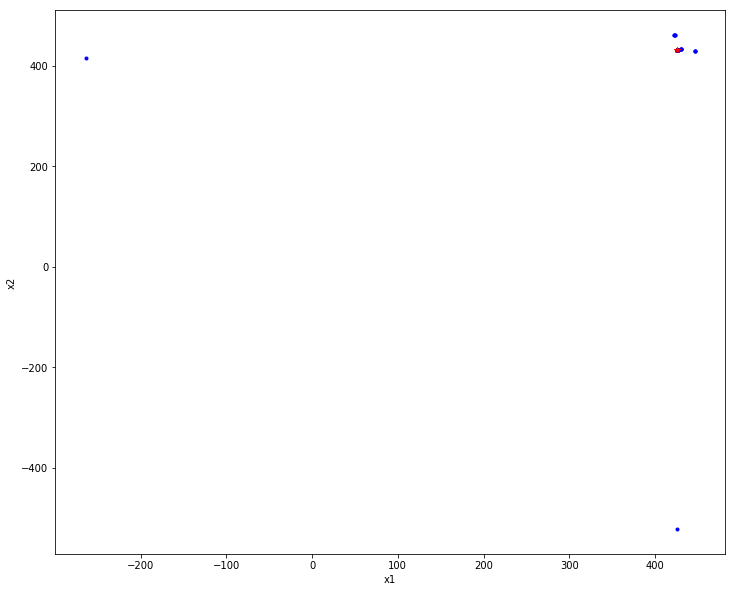

In [10]:
kite2 = KiteSwarm(
    50, #swarm_size
    2, #dim
    8, #iter_max
    15, #Nc
    20, #Np
    0.2, #integr_steps
    0.07, #step_size
    1, #closenes
    20, #deleted_kites
    1, #dist_min
    3, #k
    1) #func_num
kite2.kso_work()

In [33]:
start = time.monotonic()
time.sleep(0.1)
kite2 = KiteSwarm(
    30, #swarm_size
    2, #dim
    15, #iter_max
    5, #Nc
    7, #Np
    0.2, #integr_steps
    0.07, #step_size
    1, #closenes
    20, #deleted_kites
    1, #dist_min
    3, #k
    4) #func_num
all_mins = []
for i in range(100):
    kite2.kso_work()
    all_mins.append(kite2.exact - kite2.pool[0].f)
mean_best = np.min(np.array(all_mins))
mean_mins = np.sum(np.array(all_mins))/100
k = 0
for i in range(100):
    k += (kite2.exact - kite2.pool[0].f - mean_mins)**2
kk = (k / 100)**0.5

print(mean_mins)
print(mean_best)
print(kk)
end = time.monotonic()
print('work time : {:>9.2f}'.format(end-start))

0.00036291903033593864
0.00011445010574462344
0.00024846892459131503
work time :     95.45


4.253888

    Function defenition and its acceptable area

In [4]:
def init_area(kso):
    if kso.func_num == 0:
        kso.area = [[-5, 5], [-5, 5]]
#         kso.area_new = deepcopy(kso.area)
#         kso.area_radius = (kso.area[0][1] - kso.area[0][0]) / 5
        kso.exact = 0
        kso.function_name = 'Квадратичная'
    elif kso.func_num == 1:
        kso.area = [[-500, 500], [-500, 500]]
#         kso.area_new = deepcopy(kso.area)
#         kso.area_radius = (kso.area[0][1] - kso.area[0][0]) / 5
        kso.exact = 837.9658
        kso.function_name = 'Швефеля'
    elif kso.func_num == 2:
        kso.area = [[-2, 2], [-2, 2]]
#         kso.area_new = deepcopy(kso.area)
#         kso.area_radius = (kso.area[0][1] - kso.area[0][0]) / 5
        kso.exact = 4.253888
        kso.function_name = 'Мульти'
    elif kso.func_num == 3:
        kso.area = [[-2, 2], [-2, 2]]
#         kso.area_radius = (kso.area[0][1] - kso.area[0][0]) / 5
        kso.exact = 1
        kso.function_name = 'Корневая'
    elif kso.func_num == 4:
        kso.area = [[-10, 10], [-10, 10]]
#         kso.area_radius = (kso.area[0][1] - kso.area[0][0]) / 5
        kso.exact = 1
        kso.function_name = 'Шаффер'
    elif kso.func_num == 5:
        kso.area = [[-5, 5], [-5, 5]]
        kso.exact = 20
        kso.function_name = 'Растригин'
    elif kso.func_num == 6:
        kso.area = [[-10, 10], [-10, 10]]
        kso.exact = 20
        kso.function_name = 'Аклей'
    elif kso.func_num == 7:
        kso.area = [[-5, 5], [-5, 5]]
        kso.exact = 14.060606
        kso.function_name = ''
    elif kso.func_num == 8:
        kso.area = [[-5, 5], [-5, 5]]
        kso.exact = 1
        kso.function_name = ''
    elif kso.func_num == 9:
        kso.area = [[-3, 3], [-1, 5]]
        kso.exact = 0
        kso.function_name = ''

In [5]:
def Cpow(x, y, p):
    Cp = np.array([0, 0])
    Cp[0] = x
    Cp[1] = y
    x0 = 0
    y0 = 0
    for i in range(1, p):
        x0 = Cp[0] * x - Cp[1] * y
        y0 = Cp[1] * x + Cp[0] * y
        Cp[0] = x0
        Cp[1] = y0
    return Cp

    Function calculation: 

In [6]:
def function(kite, coordinate: List[float]):
    
    if kite.func_num == 0:
        #self.area = [[-5, 5], [-5, 5]]
        return -(np.array(coordinate)**2).sum()
    
    elif kite.func_num == 1:
        #self.area = [[-500, 500], [-500, 500]]
        return coordinate[0] * m.sin(m.sqrt(abs(coordinate[0]))) + coordinate[1] * m.sin(m.sqrt(abs(coordinate[1])))
    
    elif kite.func_num == 2:
        return coordinate[0] * m.sin(4 * m.pi * coordinate[0]) - coordinate[1] * m.sin(4 * m.pi * coordinate[1] + m.pi) +1
    
    elif kite.func_num == 3:
        c6 = Cpow(coordinate[0], coordinate[1], 6);
        func = (1 / (1 + ((c6[0] - 1)**2 + c6[1]**2)**0.5))
        return #(1 / (1 + ()**0.5))
    
    elif kite.func_num == 4:
        return 0.5 - ((m.sin((coordinate[0]**2 + coordinate[1]**2)**0.5))**2 - 0.5) / (1 + 0.001 * (coordinate[0]**2 + coordinate[1]**2))
    
    elif kite.func_num == 5:
        return (- coordinate[0]**2 + 10 * m.cos(2 * m.pi * coordinate[0])) + (-coordinate[1]**2 + 10 * m.cos(2 * m.pi * coordinate[1]))
    
    elif kite.func_num == 6:
        return - m.exp + 20 * m.exp(-0.2 * ((coordinate[0]**2 + coordinate[1]**2) / 2)**0.5) + m.exp(m.cos(2 * m.pi * coordinate[0]) + m.cos(2 * m.pi * coordinate[1])) / 2
    
    elif kite.func_num == 7:
        return (m.cos(2 * coordinate[0]) - 1.1)**2 + (m.sin(0.5 * coordinate[0]) - 1.2)**2 - (m.cos(2 * coordinate[1]) - 1.1)**2 + (m.sin(0.5 * coordinate[1]) - 1.2)**2
    
    elif kite.func_num == 8:
        return -(abs(m.sin(m.sin((abs(m.sin(coordinate[0] - 1)))**0.5 + (abs(m.sin(coordinate[1] + 2)))**0.5))))**0.5 + 1
    
    elif kite.func_num == 9:
        return -(1 - coordinate[0])**2 - 100 * (coordinate[1] - coordinate[0]**2)**2




In [7]:
def draw_plots(self):
    plt.figure(figsize=(12, 10))
    x1 = [self.pool[i].x[0] for i in range(1, len(self.pool))]
    x2 = [self.pool[i].x[1] for i in range(1, len(self.pool))]
    plt.plot(x1, x2, 'b.')
    x_1 = self.pool[0].x[0]
    x_2 = self.pool[0].x[1]
    plt.plot(x_1, x_2, color = 'red', marker = '*')
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.show()

In [8]:
def func_barr1(kite, step4):
    # определим списки
    kite.vector_x.clear()
    vector_u = []
    kite_path_barr = [] # стая на каждом шаге
    kite_population_next_step = []
    best_in_each_track = []

    # перелет каждой особи
    for k_i in range(0, kite.swarm_size):
        # очистим все списки
        vector_u = list(vector_u)
        vector_u.clear()

#         kite.vector_x - список всех векторов состояний на горизонте 

        # временно определим vector_r, x_k_i 
        kite.vector_x_ki = np.array([np.concatenate([kite.population[k_i].x, kite.population[k_i].v]) for i in range(kite.Np)])

        # deepcopy R, X_ki для мат операций
        tmp_r = deepcopy(kite.vector_r)
        tmp_x_ki = deepcopy(kite.vector_x_ki)


        # reshape R, X_ki для мат операций
        tmp_r = np.array(tmp_r).reshape((2 * kite.dim * kite.Np, 1))
        tmp_x_ki = np.array(tmp_x_ki).reshape((2 * kite.dim * kite.Np, 1))


        # --------------ОПРЕДЕЛЕНИЕ ВЕКТОРА U + reshape--------------
        u = np.linalg.inv(kite.Phi.transpose().dot(kite.Phi) + kite.Q).dot(kite.Phi.transpose()).dot(tmp_r - kite.F.dot(tmp_x_ki))
        vector_u.append(u) #зачем аппенд если можно сразу преобразовать в вектор? 

        vector_u = np.block(vector_u) #чтобы из списка преобразовать в матрицу?
        vector_u = vector_u.reshape((kite.dim, kite.Nc)).transpose()
#         print('u', '\n', vector_u)


        # --------------ОПРЕДЕЛЕНИЕ ВЕКТОРА U  для шага 2.1 или 4--------------
        if(step4 == 0):
            temp = np.zeros((kite.Nc, kite.Nc))
            temp[0, 0] = 1.0
            u = temp.dot(vector_u)
#             print('u', '\n', u)
        
        
        kite_path_barr.clear()

        # --------------ВЫЧИСЛЕНИЕ НОВЫХ КООРДИНАТ (ТЕКУЩЕГО КОРШУНА) ВЕКТОРА X_ki--------------
        # когда Nc (Nc<Np) заканчивается, u определяем как [0., 0.]
        for i in range(kite.Np):

            if(i < len(vector_u)):
                u_i = vector_u[i]
            else:
                u_i = np.zeros(kite.dim)

            tmp_x = kite.A.dot(kite.vector_x_ki[i]) + kite.B.dot(u_i) 
            coordinate = tmp_x[:kite.dim]
            velocity = tmp_x[kite.dim: kite.dim*2+1]


            # проверка на выход за границы, если вышли - берем крайнее значение
            for j in range(len(coordinate)):
                if coordinate[j] < kite.area[j][0]:
#                     print('вылетели 1')
                    coordinate[j] = kite.area[j][0]
                elif coordinate[j] > kite.area[j][1]:
#                     print('вылетели 2')
                    coordinate[j] = kite.area[j][1]

                if velocity[j] < kite.area[j][0]:
#                     print('вылетели 3')
                    velocity[j] = kite.area[j][0]
                elif velocity[j] > kite.area[j][1]:
#                     print('вылетели 4')
                    velocity[j] = kite.area[j][1]

            result = function(kite, coordinate)
            member = Kite(coordinate, velocity, result)
            kite_path_barr.append(member) #записываем сюда весь трэк коршуна, чтобы потом выбрать конкретное положение
            
        kite.vector_x.append(kite_path_barr)
        
        kite_pb = deepcopy(kite_path_barr)
        kite_pb.sort(reverse=True, key=lambda kite_: kite_.f)
#         kite_population_next_step.append(deepcopy(kite_path_barr[kite.Np-1]))
        kite_population_next_step.append(deepcopy(kite_pb[0]))
    
    kite.population.clear()
    kite.population = deepcopy(kite_population_next_step)
    kite_population_next_step.clear()

In [9]:
# step_size: float, #size of integration steps --- (h = 2 in article)
def move_kite_1(kite):
    u_step3 = []
    T = 10
    i = 0
    for kite_01 in kite.population[0:]:
        firts = 6 * (leader_kite.x - kite_01.x) / ((kite.swarm_size - i)**2 * kite.step_size**2)
        second = 4 * kite_01.v / ((kite.swarm_size - i) * kite.step_size)
        ++i
        result = firts - second
        u_step3.append(result)
    s = np.array([np.concatenate([kite.population[i].x, kite.population[i].v]) for i in range(kite.swarm_size)])
    s = np.transpose(s)
    u_step3 = np.transpose(u_step3)
    x = kite.A.dot(s) + kite.B.dot(u_step3)
    x = np.transpose(x)
    list1 = []
    for ii in range(kite.swarm_size):
        coordinate = x[ii][:kite.dim]
        velocity = x[ii][kite.dim: kite.dim*2+1]
        result = function(kite, coordinate)
        member = Kite(coordinate, velocity, result)
        list1.append(member)
    list1.sort(reverse=True, key=lambda kite_: kite_.f)
#     print(list1[1].f, list1[1].x, list1[1].v)
#     print(list1[0].f, list1[0].x, list1[0].v)
#     print(list1[2].f, list1[2].x, list1[2].v)
#     print(list1[3].f, list1[3].x, list1[3].v)
    kite.population[1] = list1[1]
    best_kite.append(list1[1])

In [10]:
def delete_kites(kite):
    # deleted_kites: float, #parameter of deleted kites --- (sigma in article)
    number_of_deleted = round(kite.deleted_kites * kite.swarm_size, 0)
    for i in range(number_of_deleted):
        if len(kite.population) != 0:
            kite.population.pop()
    for i in range(number_of_deleted):
        coordinate = np.array([np.random.rand() * \
                            (kite.area[j][1] - kite.area[j][0]) + kite.area[j][0] \
                              for j in range(kite.dim)])

        velocity = np.array([(np.random.rand() * \
                    (kite.area[j][1] - kite.area[j][0]) + kite.area[j][0]) / kite.integr_steps \
                              for j in range(kite.dim)])

        result = function(kite, coordinate)
        member = Kite(coordinate, velocity, result)
        kite.population.append(member)

# Вычисление

In [14]:
# 1 Квадратичная

In [5]:
# --------- шаг 1 ---------
start = time.monotonic()
time.sleep(0.1)
kite = KiteSwarm(
    20, #swarm_size
    2, #dim
    40, #iter_max
    5, #Nc
    10, #Np
    0.2, #integr_steps
    0.3, #step_size
    1, #closenes
    1, #deleted_kites
    1, #dist_min
    3, #k
    5) #func_num
init_area(kite)
kite.population.clear()
kite.form_first_pop()
kite.func_calculate()
kite.population.sort(reverse=True, key=lambda kite_: kite_.f)
kite.pool.append(kite.population[0])

# --------- шаг 2 --------- (добавить цикл iter_max)

kite.vector_r = np.array([np.concatenate([kite.population[0].x, kite.population[0].v]) for i in range(kite.Np)])
for j in range(kite.iter_max): 
    for i in range(kite.Nc):
        func_barr1(kite, 1)
    kite.population.sort(reverse=True, key=lambda kite_: kite_.f)
    kite.pool.append(kite.population[0])
    kite.vector_r = np.array([np.concatenate([kite.population[0].x, kite.population[0].v]) for i in range(kite.Np)])

# --------- шаг 3 ---------

    leader_kite = kite.population[0]
    leader_kite.v = np.zeros(kite.dim)
    first_kite = kite.population[1]
    second_kite = kite.population[2]
    third_kite = kite.population[3]
    best_kite = []
    move_kite_1(kite)

# --------- шаг 4 ---------

    func_barr1(kite, 0)

# --------- шаг 5 ---------
    delete_kites(kite)
    kite.population.sort(reverse=True, key=lambda kite_: kite_.f)

kite.pool.sort(reverse=True, key=lambda kite_: kite_.f)
end = time.monotonic()

print(kite.function_name,'\n')
print('work time : {:>9.2f}'.format(end-start))

print('I:\t\t', kite.pool[0].f, '\nI_exact:\t ', kite.exact, '\nI_exact - I\t ', kite.exact - kite.pool[0].f, '\n\nx: ', kite.pool[0].x, '\nv: ', kite.pool[0].v)
draw_plots(kite)

NameError: name 'init_area' is not defined

In [24]:
def kso_work(kite):
    start = time.monotonic()
    time.sleep(0.1)
    init_area(kite)
    kite.population.clear()
    kite.form_first_pop()
    kite.func_calculate()
    kite.population.sort(reverse=True, key=lambda kite_: kite_.f)
    kite.pool.append(kite.population[0])

    # --------- шаг 2 --------- (добавить цикл iter_max)

    kite.vector_r = np.array([np.concatenate([kite.population[0].x, kite.population[0].v]) for i in range(kite.Np)])
    for j in range(kite.iter_max): 
        for i in range(kite.Nc):
            func_barr1(kite, 1)
        kite.population.sort(reverse=True, key=lambda kite_: kite_.f)
        kite.pool.append(kite.population[0])
        kite.vector_r = np.array([np.concatenate([kite.population[0].x, kite.population[0].v]) for i in range(kite.Np)])

    # --------- шаг 3 ---------

        leader_kite = kite.population[0]
        leader_kite.v = np.zeros(kite.dim)
        first_kite = kite.population[1]
        second_kite = kite.population[2]
        third_kite = kite.population[3]
        best_kite = []
        move_kite_1(kite)

    # --------- шаг 4 ---------

        func_barr1(kite, 0)

    # --------- шаг 5 ---------
        delete_kites(kite)
        kite.population.sort(reverse=True, key=lambda kite_: kite_.f)

    kite.pool.sort(reverse=True, key=lambda kite_: kite_.f)
    end = time.monotonic()

    print(kite.function_name,'\n')
    print('work time : {:>9.2f}'.format(end-start))

    print('I:\t\t', kite.pool[0].f, '\nI_exact:\t ', kite.exact, '\nI_exact - I\t ', kite.exact - kite.pool[0].f, '\n\nx: ', kite.pool[0].x, '\nv: ', kite.pool[0].v)
    draw_plots(kite)

In [ ]:
kite11 = KiteSwarm(
    250, #swarm_size
    2, #dim
    40, #iter_max
    5, #Nc
    20, #Np
    0.2, #integr_steps
    0.3, #step_size
    1, #closenes
    15, #deleted_kites
    1, #dist_min
    3, #k
    2) #func_num
kso_work(kite11)

Шаффер 

work time :     89.73
I:		 0.995115255789776 
I_exact:	  1 
I_exact - I	  0.004884744210224001 

x:  [2.85498805 1.30905519] 
v:  [0. 0.]


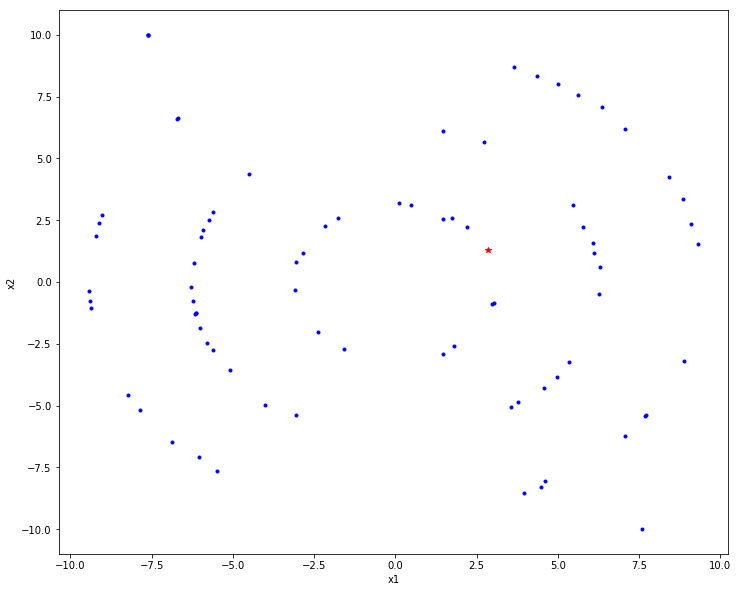

In [35]:
kite3 = KiteSwarm(
    200, #swarm_size
    2, #dim
    80, #iter_max
    10, #Nc
    10, #Np
    0.2, #integr_steps
    0.3, #step_size
    1, #closenes
    10, #deleted_kites
    1, #dist_min
    3, #k
    4) #func_num
kso_work(kite3)

Растригин 

work time :    250.42
I:		 17.128992529239078 
I_exact:	  20 
I_exact - I	  2.8710074707609223 

x:  [-1.09331826  0.0052169 ] 
v:  [  3.56140758 -16.32582349]


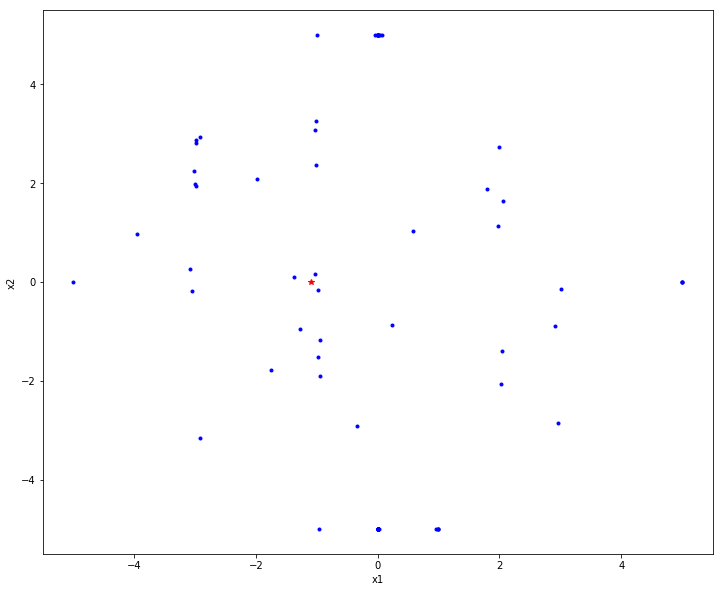

In [36]:
kite4 = KiteSwarm(
    200, #swarm_size
    2, #dim
    70, #iter_max
    15, #Nc
    30, #Np
    0.2, #integr_steps
    0.3, #step_size
    2, #closenes
    1, #deleted_kites
    1, #dist_min
    3, #k
    5) #func_num
kso_work(kite4)